<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/policy_iteration_reward_fix/Policy_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

##Policy Iteration
Policy iteration is an algorithm for evaluating the value function and improving it in successive iterations. Each iteration involves 2 steps - first step evaluates the policy and the second improves it. The first step is the same as the iterative policy evaluation algorithm and second step is the iteration policy improvement algorithm. Refer to the [Grid World notebook](https://github.com/chandrusuresh/ReinforcementLearning/blob/master/GridWorld.ipynb) for more details on these two steps/algorithms.

The state and action value function equations are summarized here:

$$\textbf{State Value Function:  }  v_{k+1}(s) = \sum_a{\pi(a|s)} \sum_{a,s'}{p(s',r|a,s) \left(r + \gamma v_k (s')\right)}  $$

$$\textbf{Action Value Function:  }  q_\pi (s,a) = \sum_{r,s'}{p(s',r|a,s) \left(r + \gamma \sum_{a'}{\pi(a'|s') q_\pi (s',a')}\right)}  $$

## Jack's Rental Car Problem

Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.

Cost of rental = \$10

Cost of moving cars = -$2

Max Cars = 20

Max cars moved = 5

Number of cars rented/returned is a Poisson distribution given by,
$$P(rented/returned = n) = \frac{\lambda^n}{n!} e^{-\lambda}$$ where $\lambda$ is the expected number.

$\lambda_{rent}^1 = 3$, $\lambda_{rent}^2 = 4$ and

$\lambda_{return}^1 = 3$,$\lambda_{return}^2 = 2$

$gamma = 0.9$
Time steps = days

State variable = Number of cars at each location at the end of the day

Action variable = Number of cars moved

## Approach

To solve this problem, we take a closer look at the independencies in the transition model.


1.   Rental counts are independent of location. $P(rent_1=m_1,rent_2=m_2) = P(rent_1=m_1) \times P(rent_2=m_2)$
2.   Return counts are independent of location. $P(return_1=n_1,return_2=n_2) = P(return_1=n_1) \times P(return_2=n_2)$
3. If Number of cars at location i at the beginning of a day = $c_i$, define $P(rent_i=m_i) = \Bigg\{ \begin{matrix} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} & \text{if  } m_i < c_i \\ 1 - \sum_{k=0}^{m_i-1} {\frac{\lambda^k}{k!} e^{-\lambda}} & otherwise \end{matrix} $

This definition is suited to compute the rewards for cases where number of rents/returns exceeds the capacity (rental capacity = $c_i$ and return capacity = $c_{max} - c_i + m_i$ and also to ensure probabilities are normalized.

For example, if $c_i = 3$, probabilities are as follows for location $i=1$:

 $m_1$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ... | $\infty$
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Poisson | 4.98e-02 | 1.49e-01 | 2.24e-01 | 2.24e-01 | 1.68e-01 | 1.01e-01 | 5.04e-02 | ... | ...
Reward  | 0 | 10 | 20 | 30 | 30 | 30 | 30 | ... | ...

Expected rental reward $\mathop{{}\mathbb{E_i}}$,
$$ \begin{align*} \mathop{{}\mathbb{E_i(c_i)}} &= \sum_{m_i=0}^{\infty}r_{rent}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= r_{rent}\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + r_{rent}c_i\sum_{m_i=c_i}^{\infty} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= r_{rent}\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + r_{rent}c_i \left( 1 - \sum_{m_i=0}^{c_i-1} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda}\right) \\ &= r_{rent}\sum_{m_i=0}^{c_i}m_iP(rent_i=m_i)\end{align*}$$

A similar definition applies for $P(return_i = n_i)$

4. Note that the rental reward is independent of the transition probability to the next state, where next state is the number of cars available for rent the next day. This is because the next state is computed as follows:
$c_{i,k+1} = c_{i,k} - m_{i,k} + n_{i,k}$
Note the additive noise in the form of returns at the end of day $k$ at location $i$ = $n_{i,k} \sim \text{Poisson}(\lambda_{return,i}) $

5. The next state $c_{i,k+1}$ is now a function of current state $c_{i,k}$, rentals in current day $m_{i,k}$ and returns in current day $n_{i,k}$. This can be summarized as follows:

Assume, $c_{i,k} = 3$, probabilities are as follows for location $i=1$. The following table, displays the next state $c_{i,k+1} = 3 - m_{i,k} + n_{i,k}$

$\begin{matrix}n_1 \rightarrow \\ m_1 \downarrow\end{matrix}$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ...
---|---|---|---|---|---|---|---|---
0|3|4|5|6|7|8|9|...
1|2|3|4|5|6|7|8|...
2|1|2|3|4|5|6|7|...
3|0|1|2|3|4|5|6|...

Note that $$P(c_{i,k+1} = m_{i,k+1}) = \sum_{m_{i,k}=0}^{c_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-c_{i,k}+m_{i,k})$$

6. Extending the above equation to include the action $a_k$,
$$P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k) = \sum_{m_{i,k}=0}^{\tilde{c}_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-\tilde{c}_{i,k}+m_{i,k})$$
where $\tilde{c}_{i,k} = c_{i,k}-(-1)^ia_k$ and $a_k \Bigg\{ \begin{matrix} \geq 0 & \text{ vehicles moved from location 1 to 2} \\ < 0 & \text{ vehicles moved from location 2 to 1} \end{matrix}$

7. Based on 1 & 2 above and expressing $s_k = \left[\begin{matrix}c_{1,k} \\ c_{2,k} \end{matrix}\right]$,
$$ P(s_{k+1}|s_k,a_k) = \prod_{i=1}^2 P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k)$$
8. Based on 4 above the current rewards and the discounted future rewards from transitions can be decoupled.
$$ P(s_{k+1},r|s_k,a_k)(r+\gamma v_{\pi}(s_{k+1}) = \sum_{i=1}^2\mathop{{}\mathbb{E_i}}(\tilde{c}_{i,k})+r_{move} \lvert a_k \rvert + \gamma P(s_{k+1}|s_k,a_k) v_{\pi}(s_{k+1})$$


### Parameters

In [0]:
max_cars = 20
max_move = 5
rent = [3,4]
retn = [3,2]
rent_cost = 10
move_cost = -2
gamma = 0.9

### Code

In [0]:
def poisson(lamda,n):
  return lamda**n/factorial(n)*np.exp(-lamda)

def modified_prob(max_n,lamda):
  prob = np.zeros((len(lamda),max_n+1))
  for k in range(max_n):
      prob[:,k] = poisson(lamda,k).reshape((len(lamda),))
  prob[:,max_n] = (1-np.sum(prob,1)).reshape((len(lamda),))
  return prob

def expected_rental_reward(c,P_rent,r_rent):
  reward = 0
  prob = []
  for i in range(len(c)):
    prob.append(np.hstack((P_rent[i,:c[i]],1-np.sum(P_rent[i,:c[i]]))))
  for i in range(c[0]+1):
    p_i = prob[0][i]
    for j in range(c[1]+1):
      p_j = prob[1][j]
      reward = reward + r_rent*(i+j)*p_i*p_j
  return reward

def get_trans_prob(c,P_rent,P_retn,idx):
  prob_rent = np.hstack((P_rent[idx,:c[idx]],1-np.sum(P_rent[idx,:c[idx]])))
  p_trans = np.zeros((max_cars+1,))
  reward = 0
  for mi in range(c[idx]+1):
    current = c[idx]-mi
    p_retn_tmp = np.hstack((P_retn[idx,:max_cars-current],1-np.sum(P_retn[idx,:max_cars-current])))
    for ni in range(len(p_retn_tmp)):
      c_next = c[idx] + ni - mi
      p_trans[c_next] = p_trans[c_next] + prob_rent[mi]*p_retn_tmp[ni]
  return p_trans

def prob_transition(c,P_rent,P_retn):
  p_trans_1 = get_trans_prob(c,P_rent,P_retn,0)
  p_trans_2 = get_trans_prob(c,P_rent,P_retn,1)
  
  p_trans = np.zeros((len(p_trans_1),len(p_trans_2)))
  for i in range(len(p_trans_1)):
    for j in range(len(p_trans_2)):
      p_trans[i,j] = p_trans_1[i]*p_trans_2[j]
  # print("Rental probability is normalized?: ",np.sum(p_trans)==1)
  return p_trans

### Pre-processing

In [0]:
## Precompute the poisson probabilities to avoid recomputing
p_rent_master = modified_prob(max_cars,np.array(rent))
p_retn_master = modified_prob(max_cars,np.array(retn))

## Misc

In [53]:
s = [3,3]
a = 3
vs = np.zeros((max_cars+1,max_cars+1))
move_cost = -2

new_s = np.array(s) - a*np.array([1,-1])

p_trans = prob_transition(new_s,p_rent_master,p_retn_master)
max_idx = np.where(p_trans==np.max(p_trans))
print('Max index:',max_idx[0],max_idx[1])
print(np.max(p_trans),p_trans[max_idx[0][0],max_idx[1][0]],p_trans[new_s[0],new_s[1]])


E = expected_rental_reward(new_s,p_rent_master,rent_cost)
cost = E +move_cost*abs(a) + np.sum(p_trans*vs)
print(cost)

# for i in range(max_cars+1):
#   for j in range(max_cars+1):
#     s = [i,j]
#     p_trans = get_trans_prob(s,p_rent_master,p_retn_master,1)
#     print(i,j,np.sum(p_trans))

if True:
# for a in act:
  new_s = np.array(s) - a*np.array([1,-1])
  E = expected_rental_reward(new_s,p_rent_master,rent_cost)
  print(a,new_s,E+move_cost*abs(a))

Max index: [2 3] [4 4]
0.038799357492710344 0.038799357492710344 0.006127505015884786
32.04565418537064
3 [0 6] 32.04565418537064


In [106]:
actions = list(range(-max_move,max_move+1))
vs_init = np.zeros((max_cars+1,max_cars+1))
pi_init = np.zeros((len(actions),vs_init.shape[0],vs_init.shape[1]))
pi_init[max_move,:,:] = 1
rent_cost = 10
move_cost = -2
print('Move Cost = ',move_cost)

def eval_policy(vs,pi):
  vs_new = np.copy(vs)
  error = 0
  for i in range(max_cars+1):
    for j in range(max_cars+1):
      s = [i,j]
      pi_s = pi[:,i,j]
      ind = np.where(pi_s > 0)[0]
      new_val = 0
      for idx in ind:
        a = actions[idx]
        new_c = np.array(s) - a*np.array([1,-1])
        p_trans = prob_transition(new_c,p_rent_master,p_retn_master)
        E = expected_rental_reward(new_c,p_rent_master,rent_cost)
        new_val = new_val + pi_s[idx]*(E + move_cost*abs(a) + gamma*np.sum(p_trans*vs_new))
      error = max(error,np.abs(new_val-vs[i,j]))
      vs_new[i,j] = new_val
  return vs_new,error

def imprv_policy(v_s):
  pi_new = np.zeros((len(actions),v_s.shape[0],v_s.shape[1]))
  for i in range(v_s.shape[0]):
    for j in range(v_s.shape[1]):
      val = dict()
      s = [i,j]
      for ai,a in enumerate(actions):
        new_c = np.array(s) - a*np.array([1,-1])
        if np.min(new_c) < 0 or np.max(new_c) > max_cars:
          continue
        new_c = np.maximum(min_num,np.minimum(max_num,new_c))
        p_trans = prob_transition(new_c,p_rent_master,p_retn_master)
        E = expected_rental_reward(new_c,p_rent_master,rent_cost)
        new_val = (E + move_cost*abs(a) + gamma*np.sum(p_trans*vs_new))
        if new_val in val.keys():
          val[new_val].append(ai)
        else:
          val[new_val] = [ai]
      max_val = np.max(list(val.keys()))
      # print(val)
      for ai in val[max_val]:
        pi_new[ai,i,j] = 1/float(len(val[max_val]))
  return pi_new

def plotAction(pi):
  action_values = np.zeros((pi.shape[1],pi.shape[2]))
  fig,ax = plt.subplots(1,1,figsize=(10,7))
  for i in range(pi.shape[1]):
    for j in range(pi.shape[2]):
      ind = np.where(pi[:,i,j] == 1)[0]
      action_values[i,j] = ind[0]-max_move

  x = list(range(max_cars+1))
  y = list(range(max_cars+1))
  X,Y = np.meshgrid(x,y)

  # fig,ax = plt.subplots(1,1,figsize=(10,7))
  cp = ax.contour(X, Y, action_values,levels=actions)
  ax.clabel(cp, inline=True, fontsize=10)
  # ax.set_title('Contour Plot')
  ax.set_xlabel('cars in location 1')
  ax.set_ylabel('cars in location 2')
  ax.grid(True)
  plt.colorbar(cp)
  plt.show()

def dispAction(pi):
  pi_new = np.zeros((pi.shape[1],pi.shape[2]))#,dtype=int)
  for i in range(pi.shape[1]):
    for j in range(pi.shape[2]):
      idx = np.where(pi[:,i,j] > 0)[0]
      if len(idx) == 1:
        pi_new[i,j] = actions[idx[0]]
  return pi_new

Move Cost =  -2


In [107]:
iter = 0
max_iter = 100
error_tol = 0.1
vs_prev = np.copy(vs_init)
pi_prev = np.copy(pi_init)

for k in range(15):
  while iter < max_iter:
    vs_new,error = eval_policy(vs_prev,pi_prev)
    # print(iter,error)
    vs_prev = np.copy(vs_new)
    if (error < error_tol):
      break
    iter = iter + 1
  print(k,iter,error)
  pi_new = imprv_policy(vs_prev)
  if np.max(np.abs(pi_new-pi_prev)) <= 1E-3:
    print('Policy iteration converged after ',k,' iterations!')
    break
  pi_prev = np.copy(pi_new)

plotAction(pi_new)
# dispAction(pi_new)

0 37 0.08606316780372936
1 55 0.08414662965424213
2 67 0.09209736688450221
3 70 0.07076254363619228
4 70 0.07720042178539188
Policy iteration converged after  4  iterations!


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -2., -2., -2.,
        -3., -3., -3., -3., -3., -4., -4., -4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -2.,
        -2., -2., -2., -2., -3., -3., -3., -3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,
        -1., -1., -1., -2., -2., -2., -2., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1., -1., -1., -1., -1., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1., -1.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  3.,  2.,  

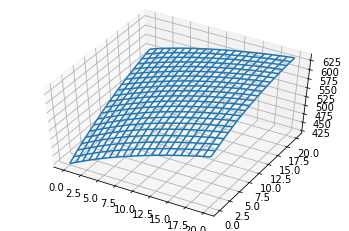

In [108]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = list(range(max_cars+1))
y = list(range(max_cars+1))
X,Y = np.meshgrid(x,y)
ax.plot_wireframe(X, Y, vs_prev)#, rstride=10, cstride=10)
ax.view_init(elev=50., azim=-60)
# azm=ax.azim
# ele=ax.elev
# print(azm,ele)